In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import graph_tool.all as gt


In [ ]:
def plot(S,I,R):
  fix, ax = plt.subplots(figsize=(8,6))
  ax.plot(np.arange(0, len(S)), S, 'g', marker = 'o', label='subsceptible')
  ax.plot(np.arange(0, len(I)), I, 'r', marker = '^', label='infected')
  ax.plot(np.arange(0, len(R)), R, 'b', marker = '*', label='recovered')
  ax.set_ylabel("Number of people")
  ax.set_xlabel("time")
  ax.legend();

## The many lives of discrete SIRs

### Version 1

In [ ]:
def run_version_1(steps, N, beta, alpha):

  # initialize
  I = 1 #patient zero
  R = 0 #recovered
  S = N-I-R #susceptible

  # observe
  history = []

  # update
  for step in range(steps):
    #variables to update
    next_S = S
    next_I = I
    next_R = R

    next_S -= beta*S*I
    next_I += beta*S*I - alpha*I
    next_R += alpha*I

    #update variables
    S = next_S
    I = next_I
    R = next_R
    history.append((S,I,R))

  St,It,Rt = map(np.array, zip(*history))
  return(St,It,Rt)

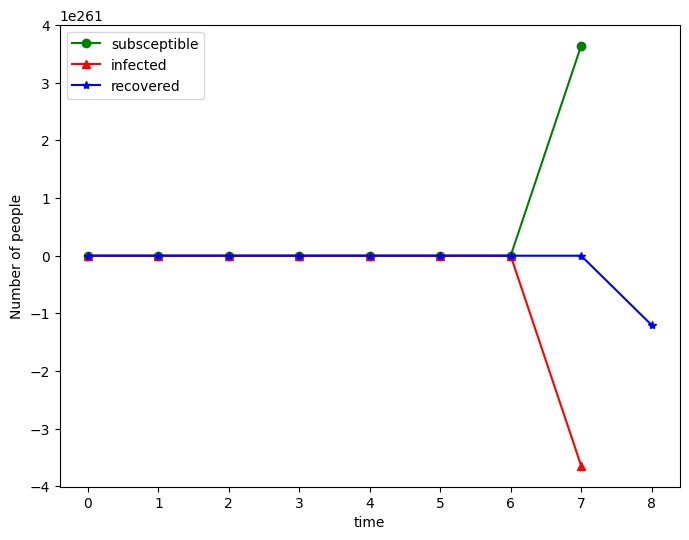

In [ ]:
# 5% probability infection; 33% recovery
(S,I,R) = run_version_1(100, 10_000, 0.05, 0.33)
plot(S,I,R)

What happened? Infecting 5% of people is a lot, even though it might seem fine.

### Version 2

In [ ]:
def run_version_2(steps, N, beta, alpha):
  """Math model"""
  # initialize
  I = 1 #patient zero
  R = 0 #recovered
  S = N-I-R #susceptible

  # observe
  history = []

  # update
  for step in range(steps):
    #variables to update
    next_S = S
    next_I = I
    next_R = R

    # WE GO BACK TO THE MATH VERSION
    next_S -= S*(1-(1-beta)**I)
    next_I += S*(1-(1-beta)**I) - alpha*I
    next_R += alpha*I

    #update variables
    S = next_S
    I = next_I
    R = next_R

    history.append((S,I,R))

  St,It,Rt = map(np.array, zip(*history))
  return(St,It,Rt)

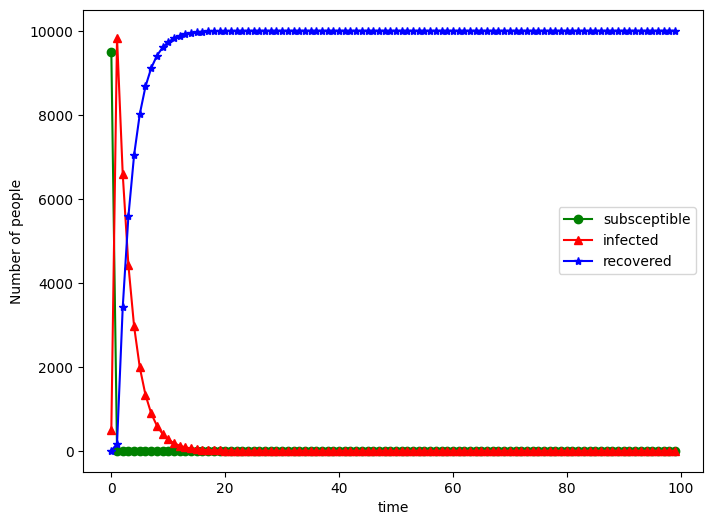

In [ ]:
# 5% probability infection; 33% recovery
(S,I,R) = run_version_2(100, 10_000, 0.05, 0.33)
plot(S,I,R)

Beta is small, but people get infected _fast_.

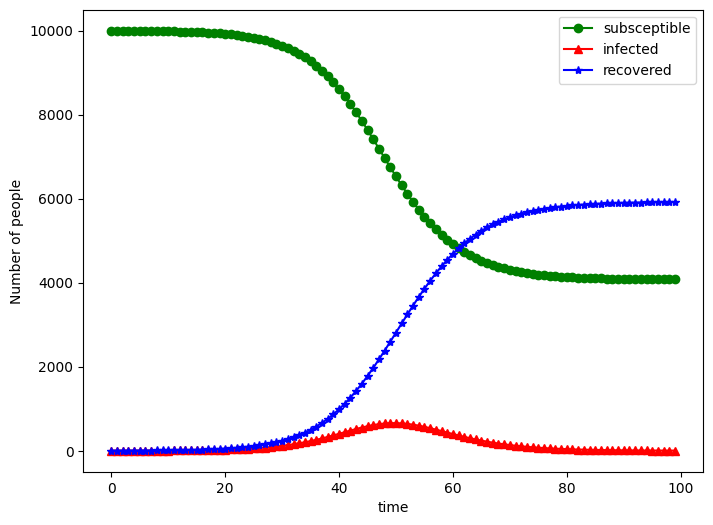

In [ ]:
# .0005% probability infection; 33% recovery
(S,I,R) = run_version_2(100, 10_000, 0.00005, 0.33)
plot(S,I,R)

### Version 3

In [ ]:
def run_version_3(steps, N, beta, alpha):
  """'Agent-based' computational approach"""
  # initialize
  I = 1 #patient zero
  R = 0 #recovered
  S = N-I-R #susceptible

  # observe
  history = []

  # update
  for step in range(steps):
    #variables to update
    next_S = S
    next_I = I
    next_R = R

    # simulate the change in a computational model
    # loop over possible infections
    for dummy_s in range(S):
     for dummy_i in range(I):
       if np.random.random(1)<beta:
         next_S -= 1
         next_I += 1
         break

    for dummy_i in range(I):
     if np.random.random(1)<alpha:
       next_I -= 1
       next_R += 1

    #update variables
    S = next_S
    I = next_I
    R = next_R

    history.append((S,I,R))

    if I==0:
        break;

  St,It,Rt = map(np.array, zip(*history))

  return(St,It,Rt)

In [ ]:
(S_c,I_c,R_c) = run_version_3(100, 10_000, 0.00005, 0.33)

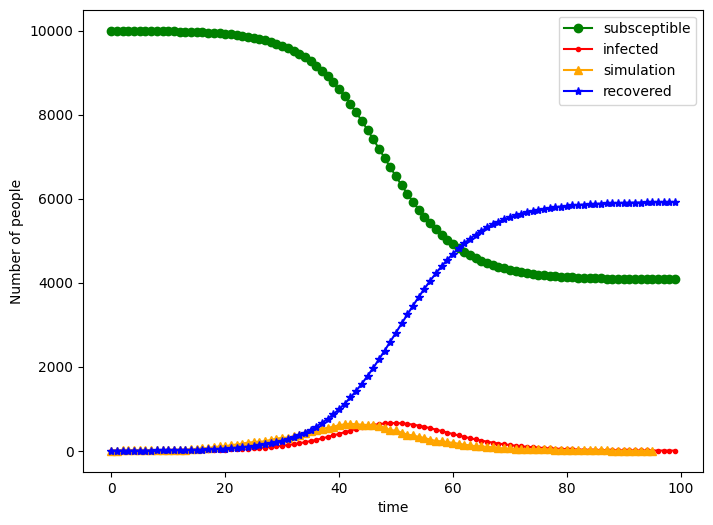

In [ ]:
fix, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(0, len(S)), S, 'g', marker = 'o', label='subsceptible')
ax.plot(np.arange(0, len(I)), I, 'r', marker = '.', label='infected')
ax.plot(np.arange(0, len(I_c)), I_c, 'orange', marker = '^', label='simulation')
ax.plot(np.arange(0, len(R)), R, 'b', marker = '*', label='recovered')
ax.set_ylabel("Number of people")
ax.set_xlabel("time")
ax.legend();

### Version 4

Where we use the binomial distribution to accelerate our computational simulations.

Probability that X will take a value less than or equal to 7: 27.0% (with CDF(k=7, n=100, p=0.094))
Example 30 draws: [8, 9, 14, 10, 8, 13, 8, 10, 13, 11, 6, 16, 7, 9, 7, 6, 5, 9, 6, 9, 7, 8, 12, 9, 7, 6, 9, 8, 8, 4]
% of draws smaller than 7: 0.2
here's the CDF


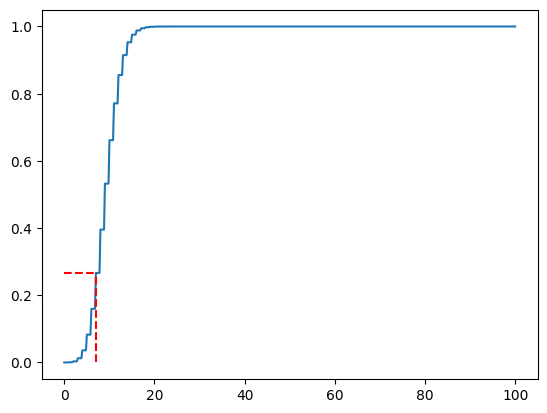

In [ ]:
#@title Binomial CDF { run: "auto" }

cutoff = 7 #@param {type:"slider", min:1, max:100, step:1}
p_cdf = 0.094 #@param {type:"slider", min:0, max:1, step:0.001}
S_fake = 100 #@param {type:"slider", min:1, max:100, step:1}

x = np.linspace(0,S_fake,500)
cdf = stats.binom.cdf
prob_below_cutoff = cdf(cutoff , S_fake, p_cdf)
print(f"Probability that X will take a value less than or equal to {cutoff}: {round(prob_below_cutoff,2)*100}% (with CDF(k={cutoff}, n={S_fake}, p={p_cdf}))")
rdm_draws = [np.random.binomial(S_fake,p_cdf) for _ in range(30)]
print(f"Example 30 draws: {rdm_draws}")
print(f"% of draws smaller than {cutoff}: {sum([draw < cutoff for draw in rdm_draws])/len(rdm_draws)}")
print("here's the CDF")
plt.plot(x,cdf(x, S_fake, p_cdf))
plt.vlines(cutoff , ymin=0, ymax=prob_below_cutoff, color="red", linestyles="dashed")
plt.hlines(prob_below_cutoff, xmin=0, xmax=cutoff, color="red", linestyles="dashed")
plt.show()

In [ ]:
import numpy as np
import random

def run_version_4(steps, N, beta, alpha):

  # initialize
  I = 1 #patient zero
  R = 0 #recovered
  S = N-I-R #susceptible

  # observe
  history = []

  # update
  for step in range(steps):
    #variables to update
    next_S = S
    next_I = I
    next_R = R

    p_inf = 1-(1-beta)**I
    new_I = np.random.binomial(S,p_inf)
    new_R = np.random.binomial(I,alpha)
    next_S -= new_I
    next_I += new_I - new_R
    next_R += new_R

    #update variables
    S = next_S
    I = next_I
    R = next_R
    history.append((S,I,R))
    if I==0:
      break;

  St,It,Rt = map(np.array, zip(*history))
  return(St,It,Rt)

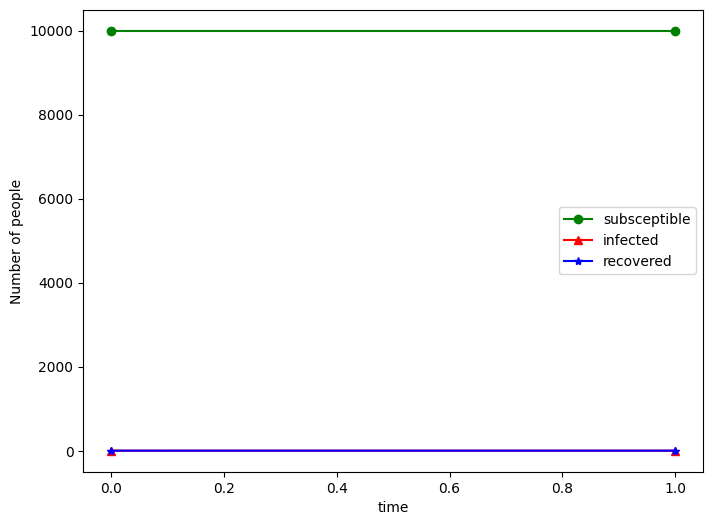

In [ ]:
(S,I,R) = run_version_4(100, 10_000, 0.00005, 0.33)
plot(S,I,R)

#### Computational vs Mathematics - round 2

In [ ]:
# easier to remember!
run_computational_SIR = run_version_4
run_mathematical_SIR = run_version_2

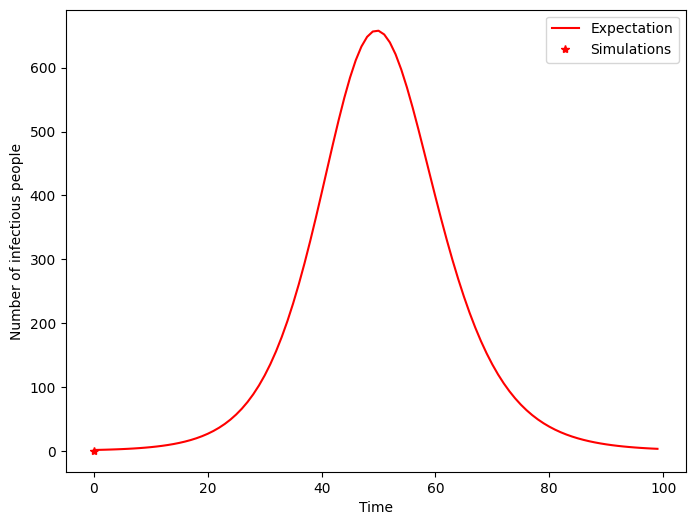

In [ ]:
(S_c,I_c,R_c) = run_computational_SIR(100, 10000, 0.00005, 0.33) # comp
(S,I,R) = run_mathematical_SIR(100, 10000, 0.00005, 0.33) # math

# Plot the results
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(0,len(I)), I, 'r', linestyle ='-',  label='Expectation')
ax.plot(np.arange(0,len(I_c)), I_c, 'r', marker ='*', linewidth=0, label='Simulations')
plt.ylabel('Number of infectious people')
plt.xlabel('Time')
ax.legend()

Say i run the following and get that:
```
> python run_computational_sir(100, 10000, 0.00005, 0.33)
(array([9999, 9997, 9996, 9995, 9994, 9994, 9991, 9991, 9991]),
 array([1, 2, 2, 2, 2, 1, 3, 2, 0]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 9]))
 ```

In [ ]:
# we calculate the next move
p_inf = 1-(1-0.00005)**2
new_I = np.random.binomial(9991,p_inf)
new_R = np.random.binomial(2,0.33)
new_I - new_R


2

## Sweep

In [ ]:
import numpy as np
import random

# Discrete SIR simulation
run_computational_SIR = run_version_4


The R-naught threshold

$$\frac{N\beta}{\alpha} = R_0$$

Crossing the rubicon

$$\beta_c > \frac{\alpha}{N}$$

Crossing the rubicon 1.217948717948718e-05


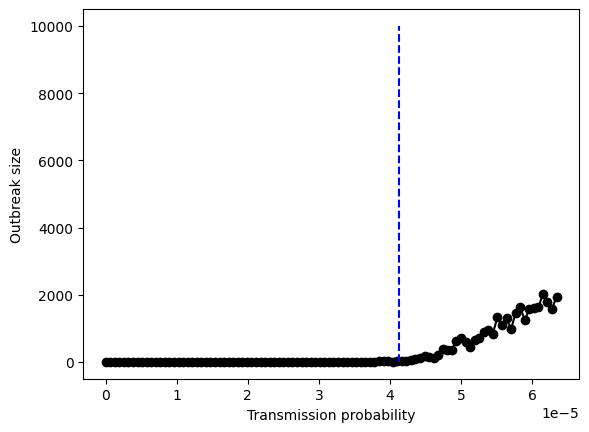

In [ ]:
#@title Statistical analysis of the SIR model { run: "auto" }
print(f"Crossing the rubicon {alpha/N}")

import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib import cm

from IPython import display
from time import sleep

# Parameters
N = 7800 #@param {type:"slider", min:100, max:20000, step:100}
steps = 1000 #@param {type:"slider", min:1, max:1000, step:1}
# probabilities
alpha = 0.322 #@param {type:"slider", min:0, max:1, step:0.001}
# statistics
repetitions = 100 #@param {type:"slider", min:1, max:200, step:1}

#run model
beta_values = np.arange(0,0.5/N,0.005/N)
outbreak_sizes = np.empty(0)
for beta in beta_values:
  results = []
  for reps in range(repetitions):
    (St,It,Rt) = run_computational_SIR(steps, N, beta, alpha)
    results.append(Rt[-1])
  outbreak_sizes = np.append(outbreak_sizes, sum(results) / len(results))

#plot
plt.plot(beta_values, outbreak_sizes, marker ='o', color='k')
plt.vlines([alpha/N], ymin=0, ymax=10_000, color="blue", linestyles="dashed", label="critical point")
plt.xlabel("Transmission probability")
plt.ylabel("Outbreak size")
plt.show()


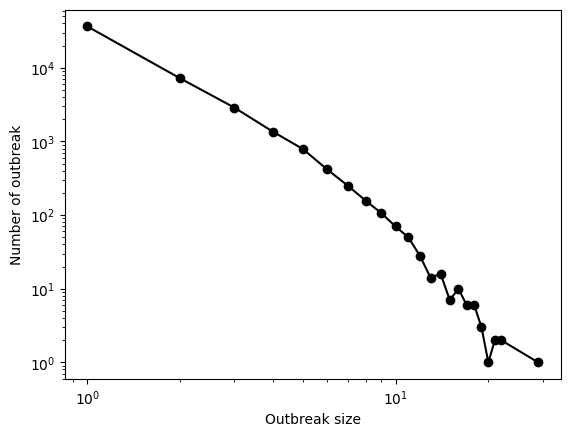

In [ ]:
#@title Statistical analysis of the SIR model { run: "auto" }

import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib import cm

from IPython import display
from time import sleep

# Parameters
N = 9000 #@param {type:"slider", min:100, max:20000, step:100}
steps = 350 #@param {type:"slider", min:1, max:1000, step:1}
# probabilities
beta = 0.000002 #@param {type:"slider", min:0, max:0.00005, step:0.000001}
alpha = 0.05 #@param {type:"slider", min:0, max:1, step:0.001}
# statistics
repetitions = 49987 #@param {type:"slider", min:1, max:100000, step:1}
results = np.zeros(repetitions)

#run model
for reps in range(repetitions):
  (St,It,Rt) = run_computational_SIR(steps, N, beta, alpha)
  results[reps] = Rt[-1]

# print(unique)
# print(counts)

#plot
unique, counts = np.unique(results, return_counts=True)
plt.loglog(np.divide(unique,1), np.divide(counts,1), marker ='o', color='k')
plt.xlabel("Outbreak size")
plt.ylabel("Number of outbreak")
plt.show()


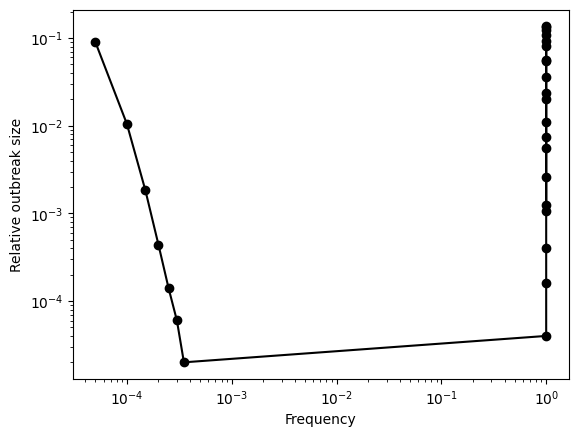

In [ ]:
#@title Statistical analysis of the SIR model (frequency version) { run: "auto" }

import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib import cm

from IPython import display
from time import sleep

# Parameters
N = 20000 #@param {type:"slider", min:100, max:20000, step:100}
steps = 1000 #@param {type:"slider", min:1, max:1000, step:1}
# probabilities
beta = 0.00002 #@param {type:"slider", min:0, max:0.00005, step:0.000001}
alpha = 0.05 #@param {type:"slider", min:0, max:1, step:0.001}
# statistics
repetitions = 49987 #@param {type:"slider", min:1, max:100000, step:1}
results = np.zeros(repetitions)

#run model
for reps in range(repetitions):
  (St,It,Rt) = run_computational_SIR(steps, N, beta, alpha)
  results[reps] = Rt[-1]

#plot
unique, counts = np.unique(results, return_counts=True)
plt.loglog(np.divide(unique,N), np.divide(counts,repetitions), marker ='o', color='k')
plt.xlabel("Frequency")
plt.ylabel("Relative outbreak size")
plt.show()


## Misinformation model

In [ ]:
import numpy as np
import random

# Discrete FIRE simulation
def run_computational_misinformation(steps, N, beta, gamma):

  # initialize
  M = 0 #patient zero
  I = N-M #susceptible

  # observe
  history = []

  # update
  for step in range(steps):
    #variables to update
    next_M = M # misinformed person
    next_I = I # informed

    p_inf = 1-(1-gamma)*(1-beta)**M  # get 'infected' _unless_ not hit by a tweet and
    new_M = np.random.binomial(I,p_inf) # none of trees currently misinformed infect me
    new_I = np.random.binomial(M,1.0) # misinformed people stay for a day
    next_M += new_M - new_I
    next_I += new_I - new_M

    #update variables
    M = next_M
    I = next_I
    history.append((M,I))

  Mt,It = map(np.array, zip(*history))
  return(Mt,It)

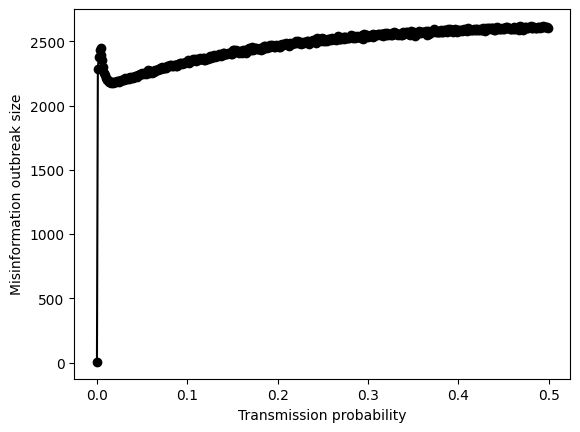

In [ ]:
#@title Statistical analysis of the misinformation model { run: "auto" }

import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib import cm

from IPython import display
from time import sleep

# Parameters
N = 5300 #@param {type:"slider", min:100, max:20000, step:100}
steps = 101 #@param {type:"slider", min:1, max:1000, step:1}
# probabilities
gamma = 0.001 #@param {type:"slider", min:0, max:1, step:0.001}
# statistics
repetitions = 100 #@param {type:"slider", min:1, max:200, step:1}

#run model
beta_values = np.arange(0,0.5,0.001)
outbreak_sizes = np.empty(0)
for beta in beta_values:
  results = []
  for reps in range(repetitions):
    (Mt,It) = run_computational_misinformation(steps, N, beta, gamma)
    results.append(np.sum(Mt[-10:-1])/10)
  outbreak_sizes = np.append(outbreak_sizes, sum(results) / len(results))

#plot
plt.plot(beta_values, outbreak_sizes, marker ='o', color='k')
plt.xlabel("Transmission probability")
plt.ylabel("Misinformation outbreak size")
plt.show()

Two process:
 - probability of new tweets coming in
 - contagion